<a href="https://colab.research.google.com/github/ab2gbl/ECG-detection/blob/main/QRS_detection/Test_of_QRS_detection_CNN%2BLSTM_70sample_MITDB_LUDB_QTDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/
#or
!mkdir '/content/physionet.org'
!mkdir '/content/physionet.org/files'
!mkdir '/content/physionet.org/files/edb'
!cp -r '/content/drive/MyDrive/Final project/dataset/physionet.org/files/edb' '/content/physionet.org/files/'
!cp -r '/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/' '/content/physionet.org/files/ecgiddb/'

In [ ]:
!pip install wfdb numpy scipy matplotlib scikit-learn tensorflow


# Gloabla variables

In [11]:
G_window_size = 70
G_overlap = 65
G_fs = 360
G_q_offset = 33

# Model Test

In [10]:
from tensorflow.keras.models import load_model
# Load the model later for inference
model = load_model("/content/drive/MyDrive/Final project/QRS detection/qrs_cnn_lstm_model_70sample_MITDB_LUDB_QTDB.h5")

## functions used

In [111]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

def bandpass_filter(data, fs, lowcut=0.5, highcut=40.0, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    filtered = signal.filtfilt(b, a, data)
    return filtered

def smooth_signal(data, window_size=5):
    # Smooth the signal using a moving average filter
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(data, window, mode='same')
    return smoothed

def normalize_signal(data):
    """
    Normalize the signal using z-score normalization.
    """
    return (data - np.mean(data)) / np.std(data)


In [112]:
def segment_signal(signal, window_size=50, overlap=40):
    """
    Segment the signal into fixed-length windows with a specified overlap.

    Args:
        signal (np.array): The input signal.
        window_size (int): Length of each segment (in samples).
        overlap (int): Number of overlapping samples between consecutive segments.

    Returns:
        tuple: (Array of segmented windows, Array of segment start indices)
    """
    segments = []
    segment_indices = []

    step = window_size - overlap  # Step size for sliding window
    for start in range(0, len(signal) - window_size + 1, step):
        end = start + window_size
        segments.append(signal[start:end])
        segment_indices.append(start)  # Store segment start position

    return np.array(segments), np.array(segment_indices)


In [113]:
import numpy as np
import matplotlib.pyplot as plt
def display_segment(normalized_signal,segment_labels,segment_starts,z_start,z_end):
  # Define sampling rate

  # Define zoom window in **seconds**
  zoom_start_sec = z_start   # Start time in seconds
  zoom_end_sec = z_end     # End time in seconds

  # Convert zoom window from seconds to samples
  zoom_start = zoom_start_sec * G_fs  # Convert to sample index
  zoom_end = zoom_end_sec * G_fs      # Convert to sample index

  # Function to filter windows within the zoom range (in sample indices)
  def filter_windows_in_zoom(windows, zoom_start, zoom_end):
      """Filter windows that fall within the zoom range in samples."""
      return [(start, end) for start, end in windows if start < zoom_end and end > zoom_start]

  # Identify segment start and end in samples
  positive_windows = [(segment_starts[i], segment_starts[i] + G_window_size) for i in range(len(segment_labels)) if segment_labels[i] == 1]
  negative_windows = [(segment_starts[i], segment_starts[i] + G_window_size) for i in range(len(segment_labels)) if segment_labels[i] == 0]
  print("Number of positive (QRS) segments:", len(positive_windows))
  print("Number of negative (non-QRS) segments:", len(negative_windows))
  # Filter positive and negative windows within the zoom range
  positive_windows_zoom = filter_windows_in_zoom(positive_windows, zoom_start, zoom_end)
  negative_windows_zoom = filter_windows_in_zoom(negative_windows, zoom_start, zoom_end)

  # Create time axis in **seconds**
  time_axis = np.arange(len(normalized_signal)) / G_fs  # Convert samples to seconds

  # Plot 1: Positive (QRS) Segments
  plt.figure(figsize=(12, 4))
  plt.plot(time_axis, normalized_signal, label="ECG Signal", color="blue")

  # Highlight positive (QRS) windows in red (only within the zoom range)
  for start, end in positive_windows_zoom:
      plt.axvspan(start / G_fs, end / G_fs, color="red", alpha=0.3, label="QRS Segment" if start == positive_windows_zoom[0][0] else "")

  plt.title(f"Positive (QRS) Segments (Window Size: {G_window_size} samples, Overlap: {G_overlap} samples)")
  plt.xlabel("Time (s)")
  plt.ylabel("Normalized Amplitude")
  plt.xlim(zoom_start_sec, zoom_end_sec)  # Zoom in on the time range
  plt.legend()
  plt.grid()
  plt.show()

  # Plot 2: Negative (Non-QRS) Segments
  plt.figure(figsize=(12, 4))
  plt.plot(time_axis, normalized_signal, label="ECG Signal", color="blue")

  # Highlight negative (non-QRS) windows in yellow (only within the zoom range)
  for start, end in negative_windows_zoom:
      plt.axvspan(start / G_fs, end / G_fs, color="yellow", alpha=0.3, label="Non-QRS Segment" if start == negative_windows_zoom[0][0] else "")
      #plt.vlines(start / G_fs, ymin=np.min(normalized_signal), ymax=np.max(normalized_signal), color="green", linestyle="dashed", alpha=0.6, label="Segment Start")

  plt.title(f"Negative (Non-QRS) Segments (Window Size: {G_window_size} samples, Overlap: {G_overlap} samples)")
  plt.xlabel("Time (s)")
  plt.ylabel("Normalized Amplitude")
  plt.xlim(zoom_start_sec, zoom_end_sec)  # Zoom in on the time range
  plt.legend()
  plt.grid()
  plt.show()


In [114]:
def remove_short_qrs_predictions(segment_labels, segmented_signal, segment_starts, min_len=4):
    filtered_labels = []
    filtered_signal = []
    filtered_starts = []

    i = 0
    while i < len(segment_labels):
        if segment_labels[i] == 1:
            # Start of a 1-run
            start = i
            while i + 1 < len(segment_labels) and segment_labels[i + 1] == 1:
                i += 1
            end = i

            run_length = end - start + 1

            if run_length >= min_len:
                # Keep only the middle of a valid QRS run
                mid = (start + end) // 2
                filtered_labels.append(1)
                filtered_signal.append(segmented_signal[mid])
                filtered_starts.append(segment_starts[mid])
            else:
                # Discard this short run
                pass
        else:
            # Keep zeros as-is
            filtered_labels.append(0)
            filtered_signal.append(segmented_signal[i])
            filtered_starts.append(segment_starts[i])
        i += 1

    return filtered_labels, filtered_signal, filtered_starts


In [115]:
def remove_touching_negatives(segment_labels, segmented_signal, segment_starts):
    new_labels = segment_labels[:]  # Copy original lists
    new_signal = segmented_signal[:]
    new_starts = segment_starts[:]

    step = G_window_size - G_overlap  # Compute the step size
    num_windows = max(1, round(G_window_size / step))-1 # Number of windows to remove (ensure at least 1)
    print(f"Number of windows to remove: {num_windows}")
    to_remove = set()  # Indices to remove

    for i, label in enumerate(segment_labels):
        if label == 1:  # If it's a positive window
            # Mark 4 windows before and after for removal
            for j in range(max(0, i - num_windows), min(len(segment_labels), i + num_windows + 1)):
                if segment_labels[j] == 0:  # Only remove negatives
                    to_remove.add(j)

    # Remove marked indices
    new_labels = [label for i, label in enumerate(segment_labels) if i not in to_remove]
    new_signal = [signal for i, signal in enumerate(segmented_signal) if i not in to_remove]
    new_starts = [start for i, start in enumerate(segment_starts) if i not in to_remove]

    return new_labels, new_signal, new_starts




In [116]:

from scipy.signal import resample
def resample_signal(signal, original_fs, target_fs=360):
    num_samples = int(len(signal) * target_fs / original_fs)
    resampled_signal = resample(signal, num_samples)
    return resampled_signal


## Testing

### edb e0601

250
360


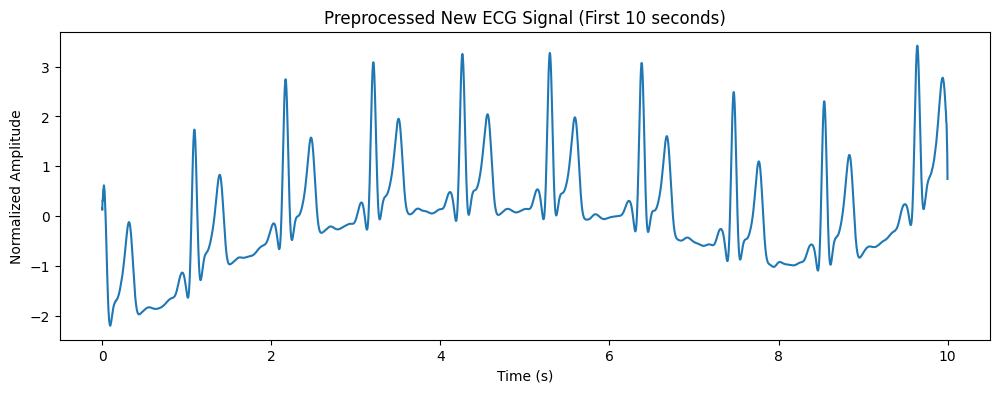

In [12]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
record_dir='/content/physionet.org/files/edb/1.0.0/'
# Load a new ECG signal (example: another record from MIT-BIH)
# Load a new ECG signal (example: another record from MIT-BIH)
# Load a new ECG signal (example: another record from MIT-BIH)
# Load a new ECG signal (example: another record from MIT-BIH)
new_record_name='e0601'
new_record_name =  record_dir + new_record_name  # Change this to the desired record
new_record = wfdb.rdrecord(new_record_name)
new_ecg_signal = new_record.p_signal[:, 0]  # Assuming single-channel ECG
G_fs = new_record.fs
print(G_fs)
new_ecg_signal = new_ecg_signal[int(15 * G_fs):int(25 * G_fs)]
# Example usage
time_axis = np.arange(0, len(new_ecg_signal)) / G_fs  # Time axis in seconds

# Optionally smooth the signal
new_normalized_signal = normalize_signal(smooth_signal(bandpass_filter(new_ecg_signal, 1000), window_size=5))
if G_fs != 360:
            new_normalized_signal = resample_signal(new_normalized_signal, original_fs=G_fs, target_fs=360)
            G_fs = 360

print(G_fs)
# Visualize the preprocessed signal
import matplotlib.pyplot as plt
time_axis = [i / G_fs for i in range(len(new_normalized_signal))]
plt.figure(figsize=(12, 4))
plt.plot(time_axis[:G_fs * 10], new_normalized_signal[:G_fs * 10])
plt.title("Preprocessed New ECG Signal (First 10 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Amplitude")
plt.show()




In [13]:



# Segment the normalized signal
new_segments,new_start_segments = segment_signal(new_normalized_signal, window_size=G_window_size, overlap=G_overlap)

print(f"Extracted {len(new_segments)} segments with window size {G_window_size} and {G_overlap} samples overlap.")



Extracted 707 segments with window size 70 and 65 samples overlap.


In [14]:
# Reshape segments for CNN+LSTM (adding a channel dimension)
new_segments_reshaped = new_segments.reshape(new_segments.shape[0], new_segments.shape[1], 1)

# Print the shape
print("Shape of input segments for model:", new_segments_reshaped.shape)


Shape of input segments for model: (707, 70, 1)


In [15]:
# Predict using the trained model
predictions = model.predict(new_segments_reshaped)

# Convert predictions to binary labels (threshold at 0.5)
predicted_labels = (predictions > 0.5).astype(int)

# Print results
print("Predicted QRS presence for each segment:", predicted_labels.flatten())


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
Predicted QRS presence for each segment: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 

Number of positive (QRS) segments: 63
Number of negative (non-QRS) segments: 644


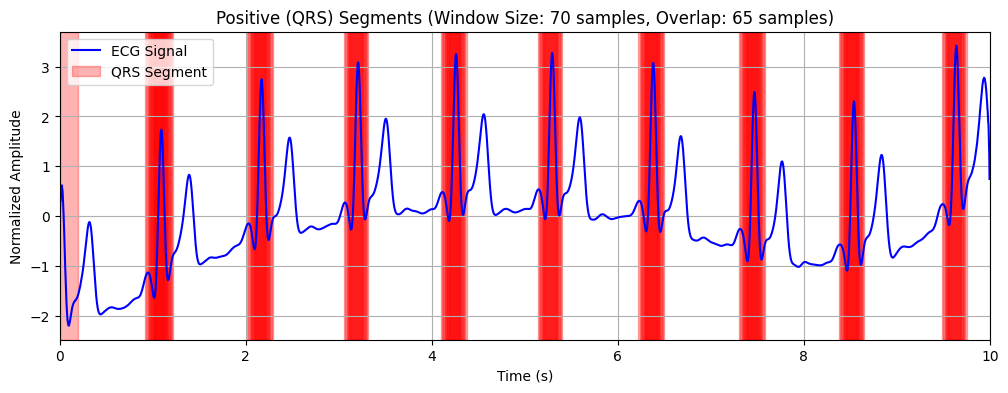

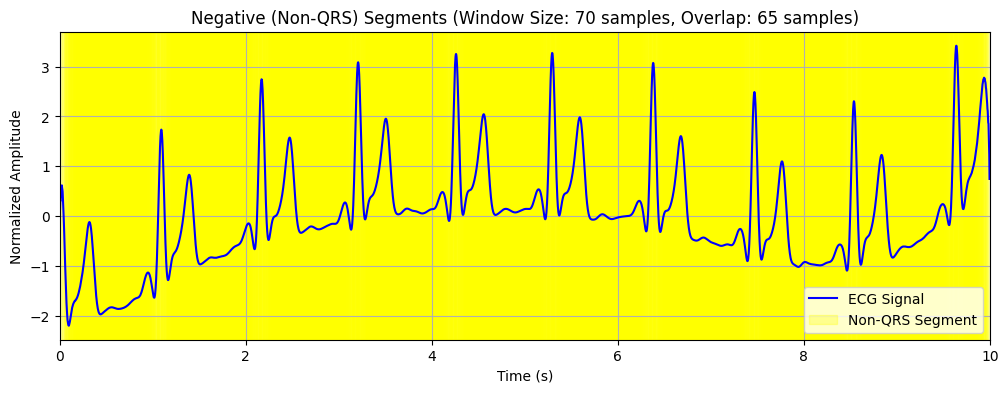

In [16]:
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,10)

Number of positive (QRS) segments: 63
Number of negative (non-QRS) segments: 644


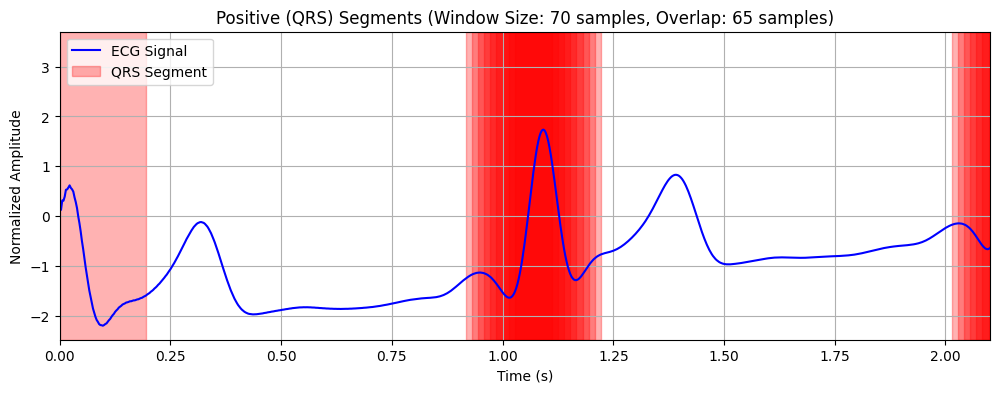

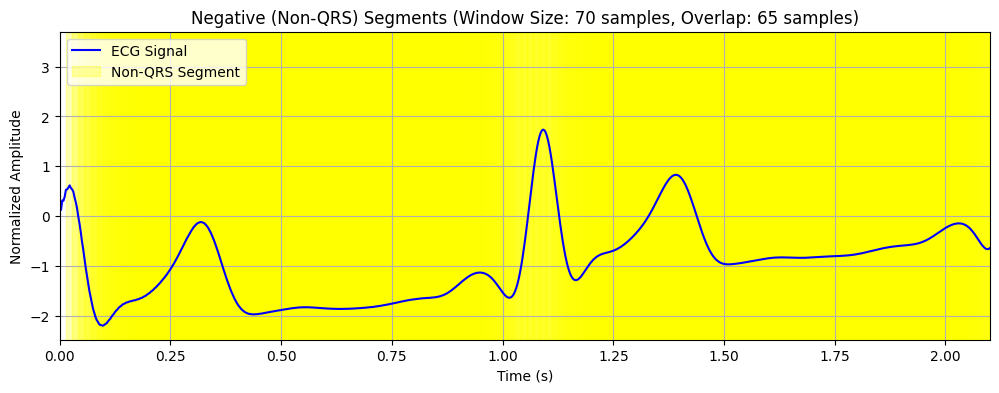

In [17]:
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,2.1)

#### improvement

Number of positive (QRS) segments: 9
Number of negative (non-QRS) segments: 644


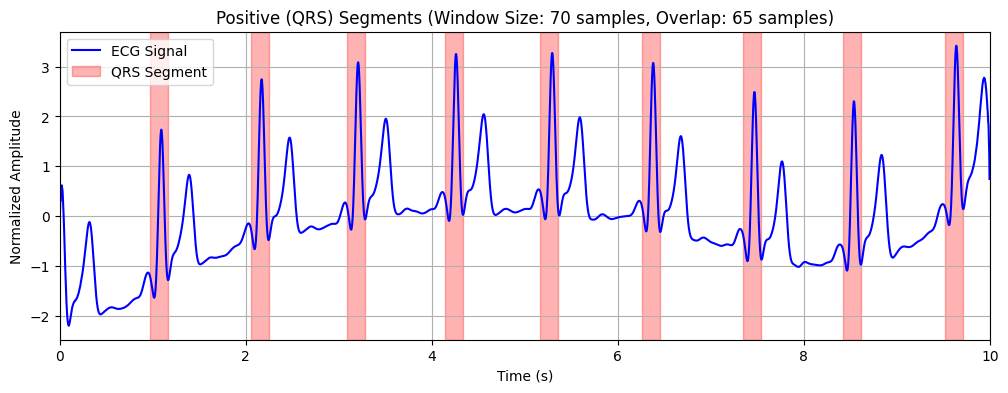

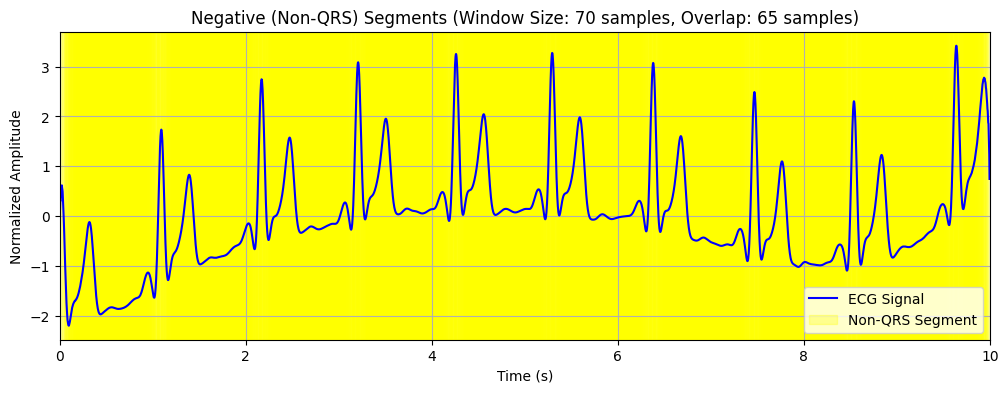

In [18]:
predicted_labels, new_segments, new_start_segments = remove_short_qrs_predictions( predicted_labels, new_segments, new_start_segments)
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,10)

Number of windows to remove: 13
Number of positive (QRS) segments: 9
Number of negative (non-QRS) segments: 410


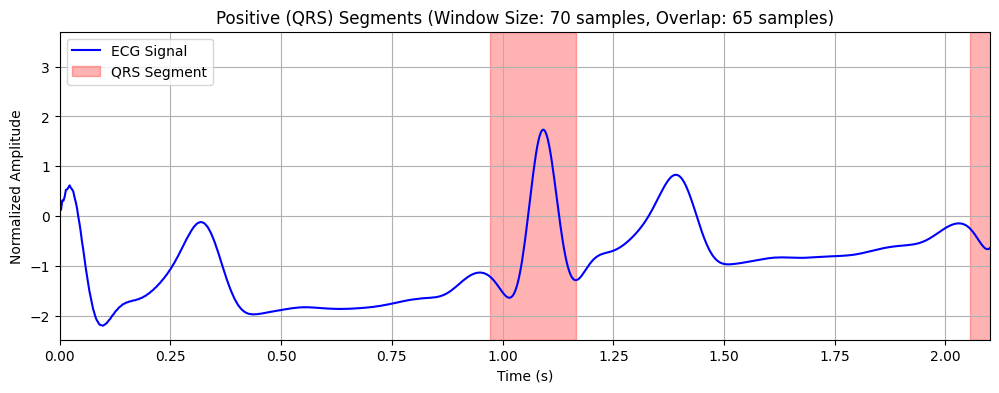

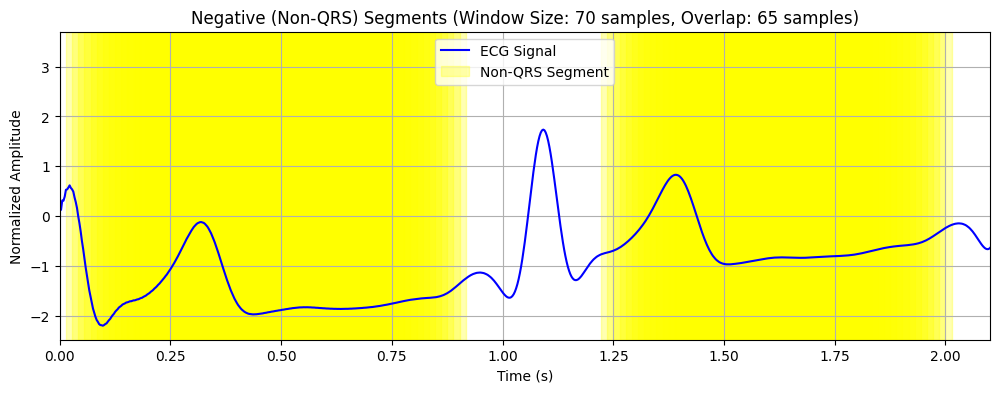

In [19]:

# Example usage:
predicted_labels, new_segments, new_start_segments = remove_touching_negatives( predicted_labels, new_segments, new_start_segments)
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,2.1)

### edb e0211

250
360


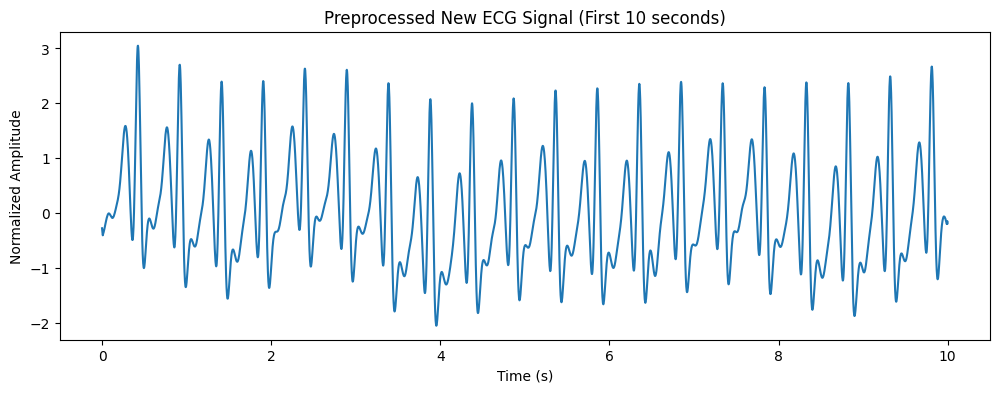

In [20]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
record_dir='/content/physionet.org/files/edb/1.0.0/'
# Load a new ECG signal (example: another record from MIT-BIH)
# Load a new ECG signal (example: another record from MIT-BIH)
# Load a new ECG signal (example: another record from MIT-BIH)
# Load a new ECG signal (example: another record from MIT-BIH)
new_record_name='e0211'
new_record_name =  record_dir + new_record_name  # Change this to the desired record
new_record = wfdb.rdrecord(new_record_name)
new_ecg_signal = new_record.p_signal[:, 0]  # Assuming single-channel ECG
G_fs = new_record.fs
print(G_fs)
new_ecg_signal = new_ecg_signal[int(15 * G_fs):int(25 * G_fs)]
# Example usage
time_axis = np.arange(0, len(new_ecg_signal)) / G_fs  # Time axis in seconds

# Optionally smooth the signal
new_normalized_signal = normalize_signal(smooth_signal(bandpass_filter(new_ecg_signal, 1000), window_size=5))
if G_fs != 360:
            new_normalized_signal = resample_signal(new_normalized_signal, original_fs=G_fs, target_fs=360)
            G_fs = 360

print(G_fs)
# Visualize the preprocessed signal
import matplotlib.pyplot as plt
time_axis = [i / G_fs for i in range(len(new_normalized_signal))]
plt.figure(figsize=(12, 4))
plt.plot(time_axis[:G_fs * 10], new_normalized_signal[:G_fs * 10])
plt.title("Preprocessed New ECG Signal (First 10 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Amplitude")
plt.show()




In [21]:



# Segment the normalized signal
new_segments,new_start_segments = segment_signal(new_normalized_signal, window_size=G_window_size, overlap=G_overlap)

print(f"Extracted {len(new_segments)} segments with window size {G_window_size} and {G_overlap} samples overlap.")



Extracted 707 segments with window size 70 and 65 samples overlap.


In [22]:
# Reshape segments for CNN+LSTM (adding a channel dimension)
new_segments_reshaped = new_segments.reshape(new_segments.shape[0], new_segments.shape[1], 1)

# Print the shape
print("Shape of input segments for model:", new_segments_reshaped.shape)


Shape of input segments for model: (707, 70, 1)


In [23]:
# Predict using the trained model
predictions = model.predict(new_segments_reshaped)

# Convert predictions to binary labels (threshold at 0.5)
predicted_labels = (predictions > 0.5).astype(int)

# Print results
print("Predicted QRS presence for each segment:", predicted_labels.flatten())


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Predicted QRS presence for each segment: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 

Number of positive (QRS) segments: 159
Number of negative (non-QRS) segments: 548


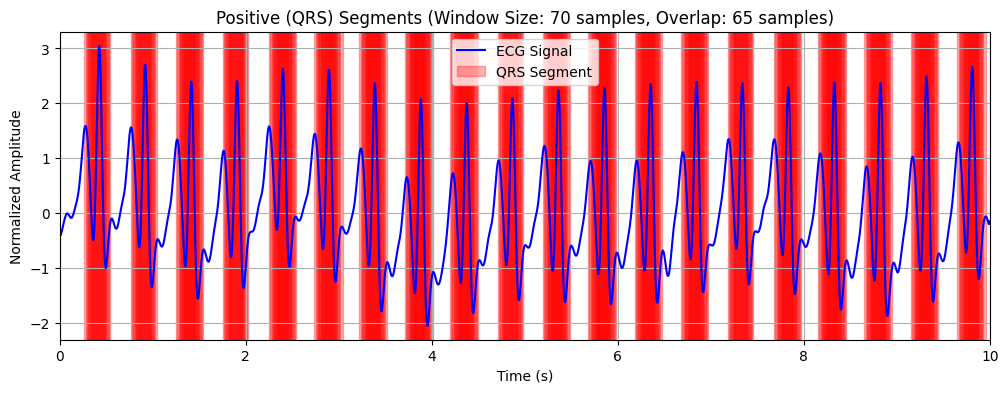

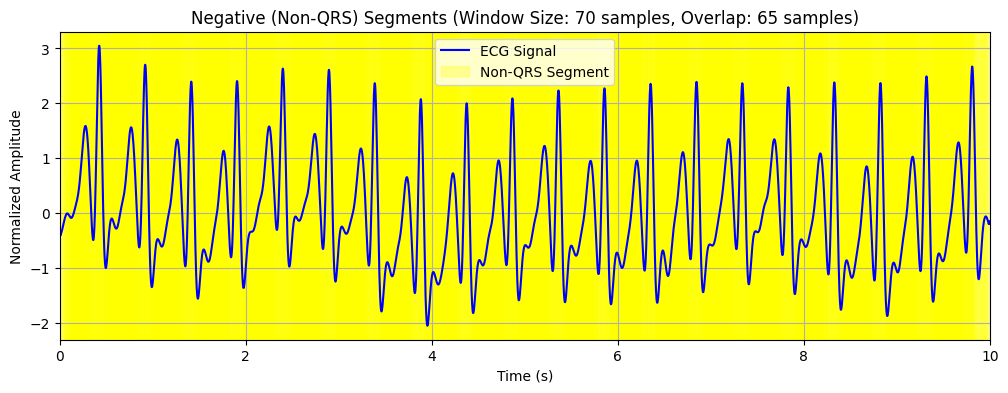

In [24]:
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,10)

Number of positive (QRS) segments: 159
Number of negative (non-QRS) segments: 548


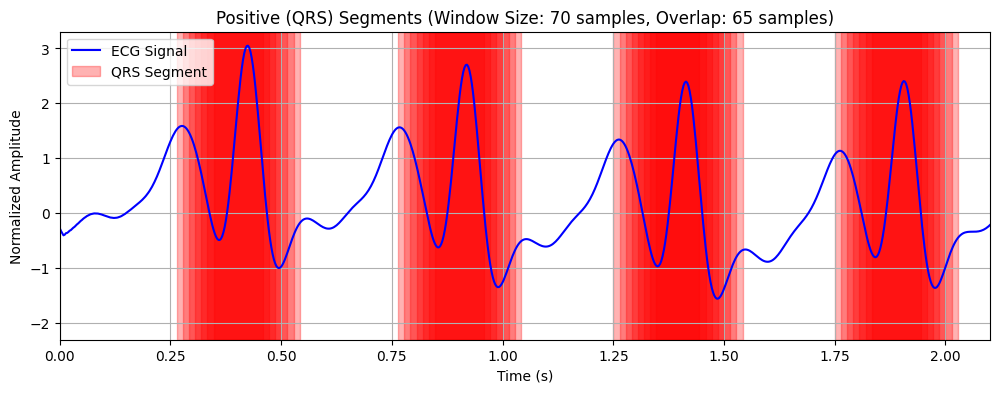

In [25]:
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,2.1)

#### improvement

Number of positive (QRS) segments: 20
Number of negative (non-QRS) segments: 548


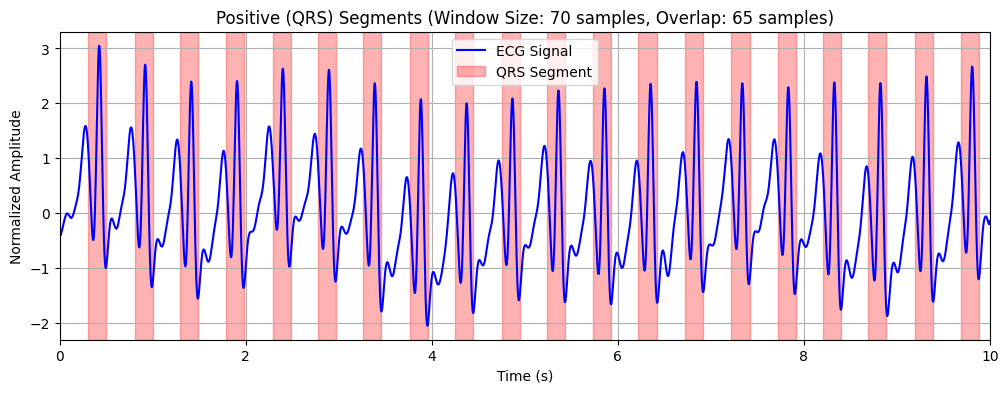

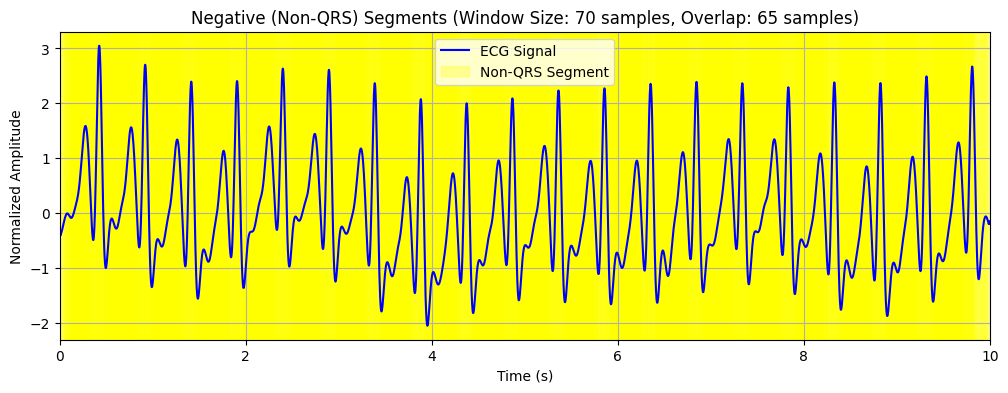

In [26]:
predicted_labels, new_segments, new_start_segments = remove_short_qrs_predictions( predicted_labels, new_segments, new_start_segments)
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,10)

Number of windows to remove: 13
Number of positive (QRS) segments: 20
Number of negative (non-QRS) segments: 37


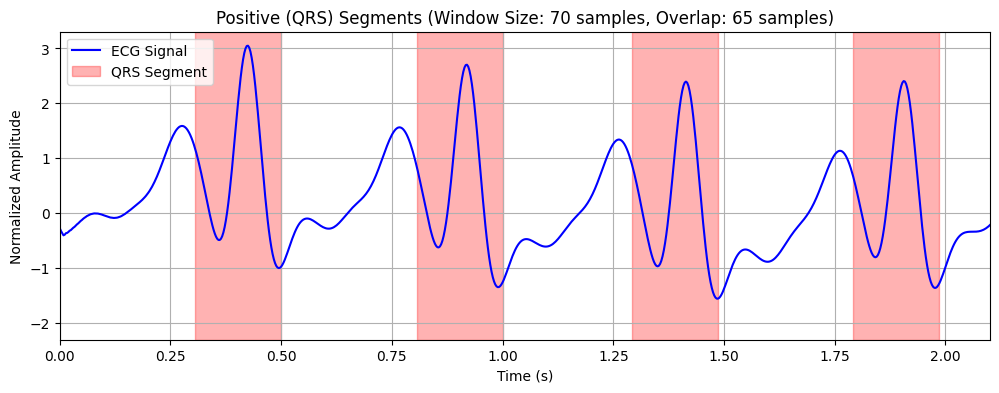

In [27]:

# Example usage:
predicted_labels, new_segments, new_start_segments = remove_touching_negatives( predicted_labels, new_segments, new_start_segments)
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,2.1)

### edb e1304

250
360


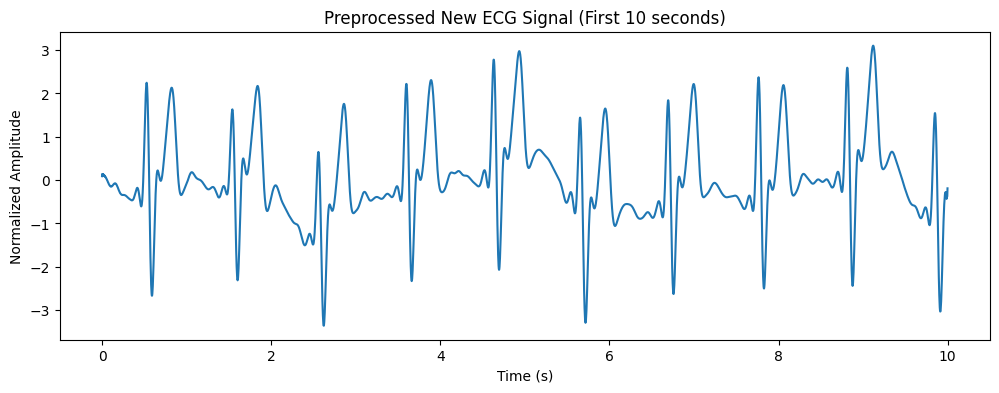

In [28]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
record_dir='/content/physionet.org/files/edb/1.0.0/'
# Load a new ECG signal (example: another record from MIT-BIH)
# Load a new ECG signal (example: another record from MIT-BIH)
# Load a new ECG signal (example: another record from MIT-BIH)
# Load a new ECG signal (example: another record from MIT-BIH)
new_record_name='e1304'
new_record_name =  record_dir + new_record_name  # Change this to the desired record
new_record = wfdb.rdrecord(new_record_name)
new_ecg_signal = new_record.p_signal[:, 0]  # Assuming single-channel ECG
G_fs = new_record.fs
print(G_fs)
new_ecg_signal = new_ecg_signal[int(15 * G_fs):int(25 * G_fs)]
# Example usage
time_axis = np.arange(0, len(new_ecg_signal)) / G_fs  # Time axis in seconds

# Optionally smooth the signal
new_normalized_signal = normalize_signal(smooth_signal(bandpass_filter(new_ecg_signal, 1000), window_size=5))
if G_fs != 360:
            new_normalized_signal = resample_signal(new_normalized_signal, original_fs=G_fs, target_fs=360)
            G_fs = 360

print(G_fs)
# Visualize the preprocessed signal
import matplotlib.pyplot as plt
time_axis = [i / G_fs for i in range(len(new_normalized_signal))]
plt.figure(figsize=(12, 4))
plt.plot(time_axis[:G_fs * 10], new_normalized_signal[:G_fs * 10])
plt.title("Preprocessed New ECG Signal (First 10 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Amplitude")
plt.show()




In [29]:



# Segment the normalized signal
new_segments,new_start_segments = segment_signal(new_normalized_signal, window_size=G_window_size, overlap=G_overlap)

print(f"Extracted {len(new_segments)} segments with window size {G_window_size} and {G_overlap} samples overlap.")



Extracted 707 segments with window size 70 and 65 samples overlap.


In [30]:
# Reshape segments for CNN+LSTM (adding a channel dimension)
new_segments_reshaped = new_segments.reshape(new_segments.shape[0], new_segments.shape[1], 1)

# Print the shape
print("Shape of input segments for model:", new_segments_reshaped.shape)


Shape of input segments for model: (707, 70, 1)


In [31]:
# Predict using the trained model
predictions = model.predict(new_segments_reshaped)

# Convert predictions to binary labels (threshold at 0.5)
predicted_labels = (predictions > 0.5).astype(int)

# Print results
print("Predicted QRS presence for each segment:", predicted_labels.flatten())


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predicted QRS presence for each segment: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 

In [32]:
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,10)

Number of positive (QRS) segments: 77
Number of negative (non-QRS) segments: 630


In [33]:
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,2.1)

Number of positive (QRS) segments: 77
Number of negative (non-QRS) segments: 630


#### improvement

Number of positive (QRS) segments: 10
Number of negative (non-QRS) segments: 630


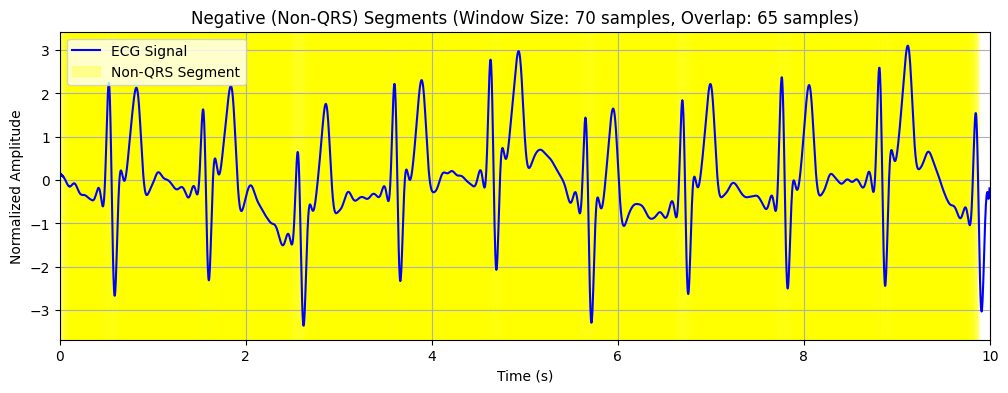

In [34]:
predicted_labels, new_segments, new_start_segments = remove_short_qrs_predictions( predicted_labels, new_segments, new_start_segments)
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,10)

Number of windows to remove: 13
Number of positive (QRS) segments: 10
Number of negative (non-QRS) segments: 383


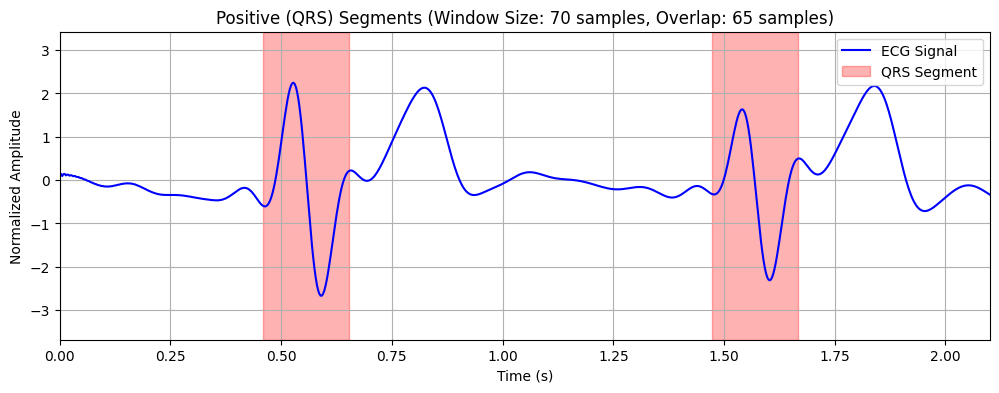

In [35]:

# Example usage:
predicted_labels, new_segments, new_start_segments = remove_touching_negatives( predicted_labels, new_segments, new_start_segments)
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,2.1)

### ecgiddb Person_02/rec_1

500
360


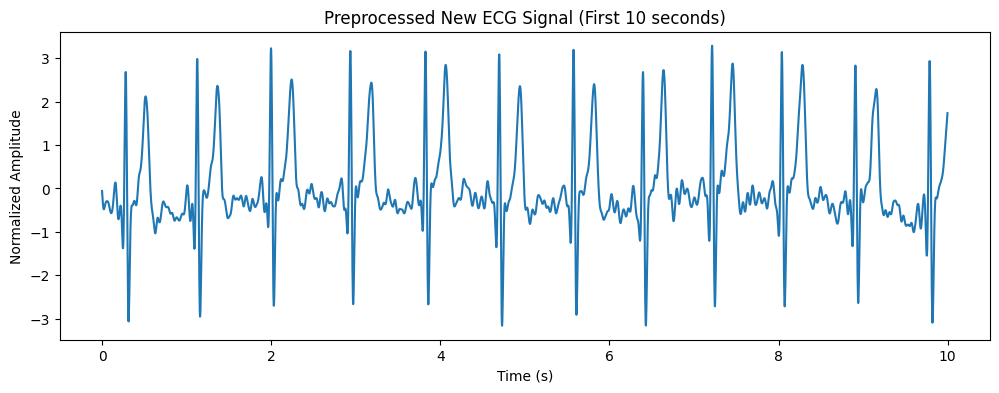

In [87]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
record_dir='/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/'
# Load a new ECG signal (example: another record from MIT-BIH)
# Load a new ECG signal (example: another record from MIT-BIH)
# Load a new ECG signal (example: another record from MIT-BIH)
# Load a new ECG signal (example: another record from MIT-BIH)
new_record_name='Person_02/rec_1'
new_record_name =  record_dir + new_record_name  # Change this to the desired record
new_record = wfdb.rdrecord(new_record_name)
new_ecg_signal = new_record.p_signal[:, 0]  # Assuming single-channel ECG
G_fs = new_record.fs
print(G_fs)
# Example usage
time_axis = np.arange(0, len(new_ecg_signal)) / G_fs  # Time axis in seconds

new_normalized_signal = normalize_signal(smooth_signal(bandpass_filter(new_ecg_signal, 1000), window_size=5))
if G_fs != 360:
            new_normalized_signal = resample_signal(new_normalized_signal, original_fs=G_fs, target_fs=360)
            G_fs = 360

print(G_fs)
# Visualize the preprocessed signal
import matplotlib.pyplot as plt
time_axis = [i / G_fs for i in range(len(new_normalized_signal))]
plt.figure(figsize=(12, 4))
plt.plot(time_axis[:G_fs * 10], new_normalized_signal[:G_fs * 10])
plt.title("Preprocessed New ECG Signal (First 10 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Amplitude")
plt.show()




In [88]:



# Segment the normalized signal
new_segments,new_start_segments = segment_signal(new_normalized_signal, window_size=G_window_size, overlap=G_overlap)

print(f"Extracted {len(new_segments)} segments with window size {G_window_size} and {G_overlap} samples overlap.")



Extracted 1427 segments with window size 70 and 65 samples overlap.


In [89]:
# Reshape segments for CNN+LSTM (adding a channel dimension)
new_segments_reshaped = new_segments.reshape(new_segments.shape[0], new_segments.shape[1], 1)

# Print the shape
print("Shape of input segments for model:", new_segments_reshaped.shape)


Shape of input segments for model: (1427, 70, 1)


In [90]:
# Predict using the trained model
predictions = model.predict(new_segments_reshaped)

# Convert predictions to binary labels (threshold at 0.5)
predicted_labels = (predictions > 0.5).astype(int)

# Print results
print("Predicted QRS presence for each segment:", predicted_labels.flatten())


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Predicted QRS presence for each segment: [0 0 0 ... 0 0 0]


Number of positive (QRS) segments: 224
Number of negative (non-QRS) segments: 1203


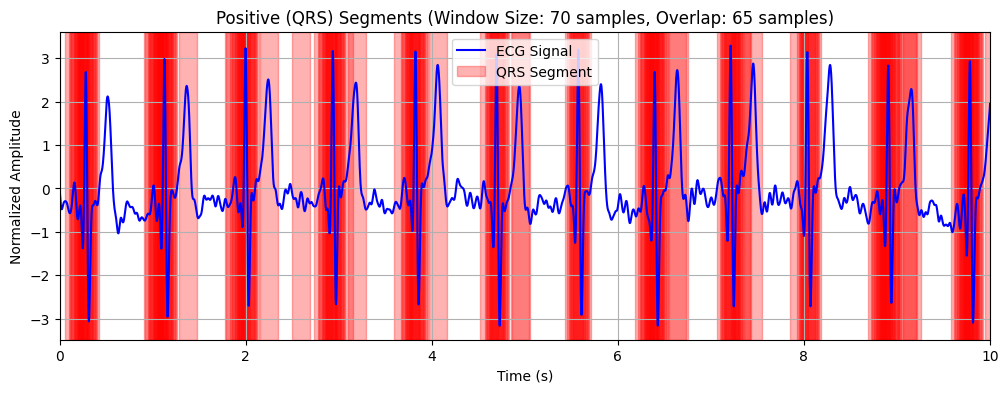

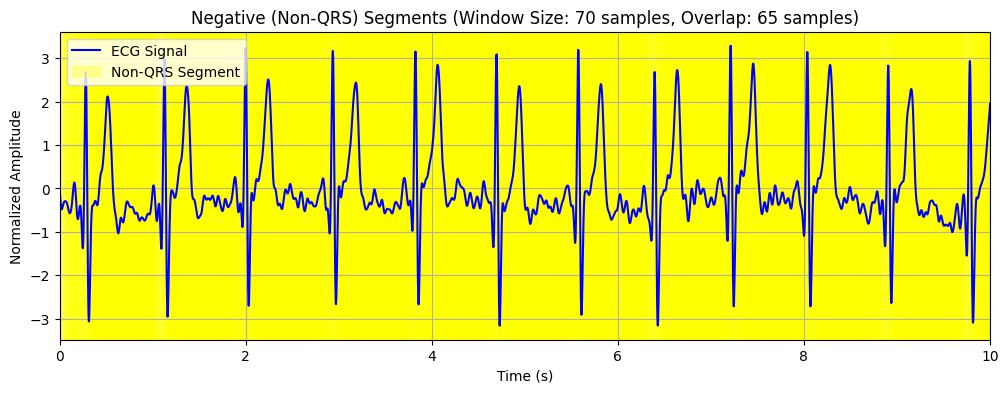

In [91]:
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,10)

Number of positive (QRS) segments: 224
Number of negative (non-QRS) segments: 1203


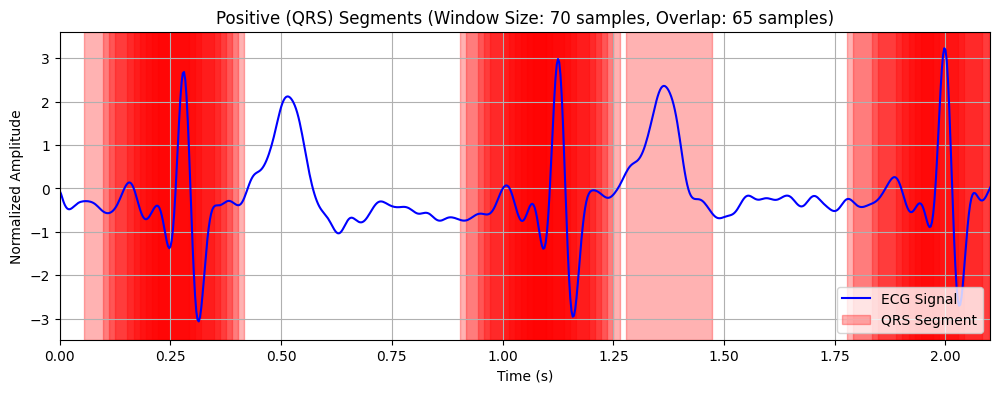

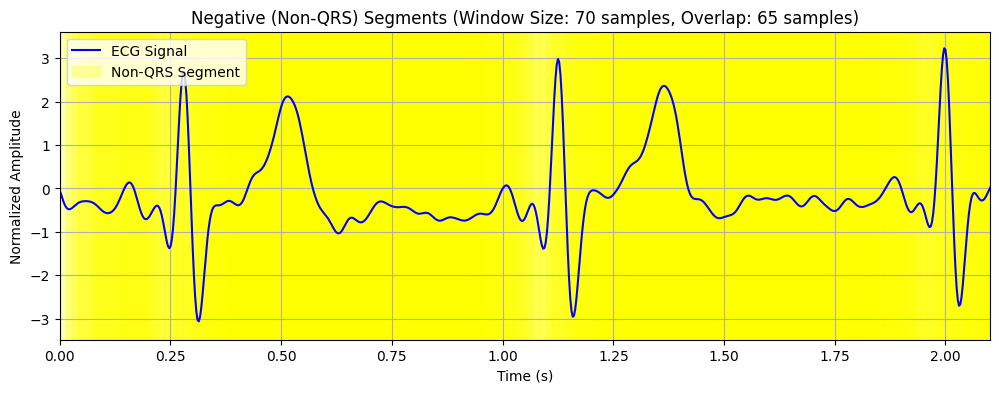

In [92]:
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,2.1)

#### improvement

Number of positive (QRS) segments: 23
Number of negative (non-QRS) segments: 1203


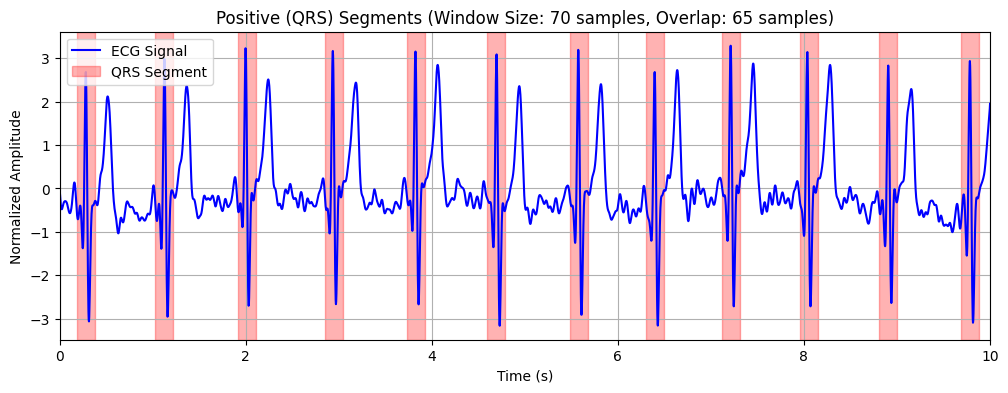

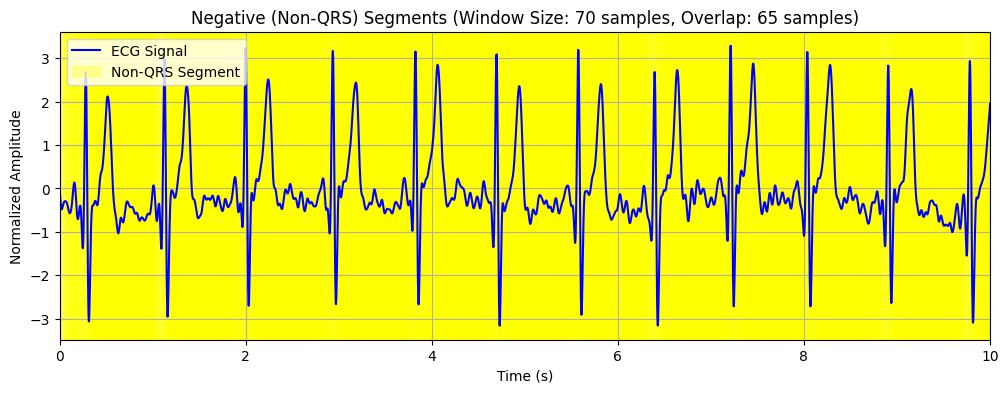

In [93]:
predicted_labels, new_segments, new_start_segments = remove_short_qrs_predictions( predicted_labels, new_segments, new_start_segments)
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,10)

Number of windows to remove: 13
Number of positive (QRS) segments: 23
Number of negative (non-QRS) segments: 611


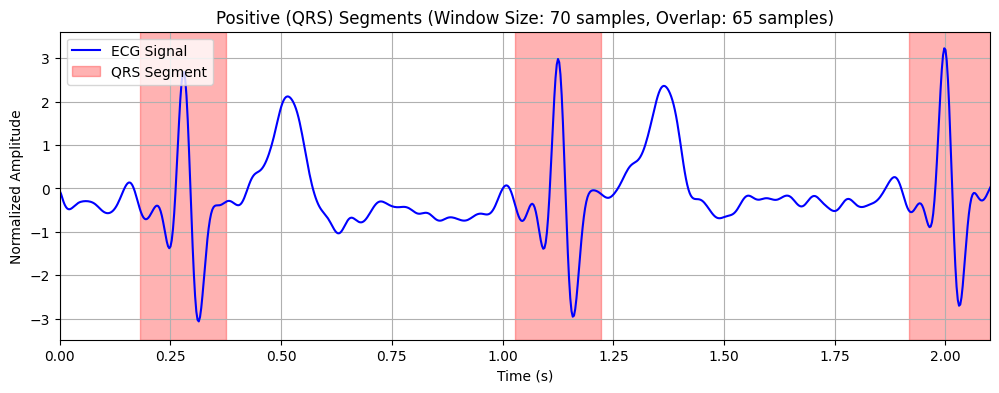

In [94]:

# Example usage:
predicted_labels, new_segments, new_start_segments = remove_touching_negatives( predicted_labels, new_segments, new_start_segments)
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,2.1)

Number of positive (QRS) segments: 23
Number of negative (non-QRS) segments: 611


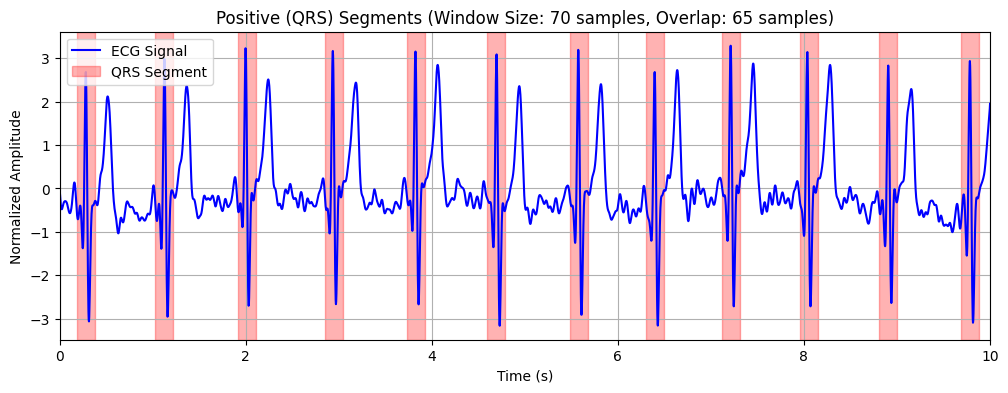

In [95]:
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,10)

### ecgiddb Person_48/rec_1

500
360


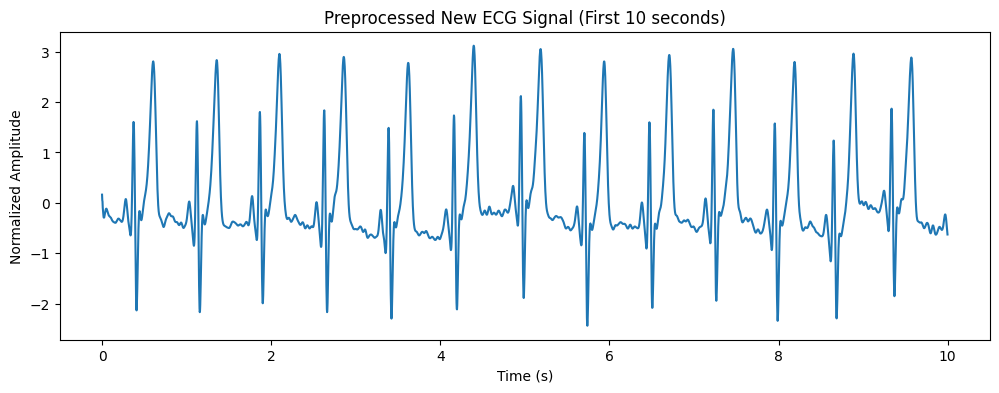

In [145]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
record_dir='/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/'
# Load a new ECG signal (example: another record from MIT-BIH)
# Load a new ECG signal (example: another record from MIT-BIH)
# Load a new ECG signal (example: another record from MIT-BIH)
# Load a new ECG signal (example: another record from MIT-BIH)
new_record_name='Person_48/rec_1'
new_record_name =  record_dir + new_record_name  # Change this to the desired record
new_record = wfdb.rdrecord(new_record_name)
new_ecg_signal = new_record.p_signal[:, 0]  # Assuming single-channel ECG
G_fs = new_record.fs
print(G_fs)
# Example usage
time_axis = np.arange(0, len(new_ecg_signal)) / G_fs  # Time axis in seconds

new_normalized_signal = normalize_signal(smooth_signal(bandpass_filter(new_ecg_signal, 1000), window_size=5))
if G_fs != 360:
            new_normalized_signal = resample_signal(new_normalized_signal, original_fs=G_fs, target_fs=360)
            G_fs = 360

print(G_fs)
# Visualize the preprocessed signal
import matplotlib.pyplot as plt
time_axis = [i / G_fs for i in range(len(new_normalized_signal))]
plt.figure(figsize=(12, 4))
plt.plot(time_axis[:G_fs * 10], new_normalized_signal[:G_fs * 10])
plt.title("Preprocessed New ECG Signal (First 10 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Amplitude")
plt.show()




In [146]:



# Segment the normalized signal
new_segments,new_start_segments = segment_signal(new_normalized_signal, window_size=G_window_size, overlap=G_overlap)

print(f"Extracted {len(new_segments)} segments with window size {G_window_size} and {G_overlap} samples overlap.")



Extracted 1427 segments with window size 70 and 65 samples overlap.


In [147]:
# Reshape segments for CNN+LSTM (adding a channel dimension)
new_segments_reshaped = new_segments.reshape(new_segments.shape[0], new_segments.shape[1], 1)

# Print the shape
print("Shape of input segments for model:", new_segments_reshaped.shape)


Shape of input segments for model: (1427, 70, 1)


In [148]:
# Predict using the trained model
predictions = model.predict(new_segments_reshaped)

# Convert predictions to binary labels (threshold at 0.5)
predicted_labels = (predictions > 0.5).astype(int)

# Print results
print("Predicted QRS presence for each segment:", predicted_labels.flatten())


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predicted QRS presence for each segment: [0 0 0 ... 0 0 0]


Number of positive (QRS) segments: 180
Number of negative (non-QRS) segments: 1247


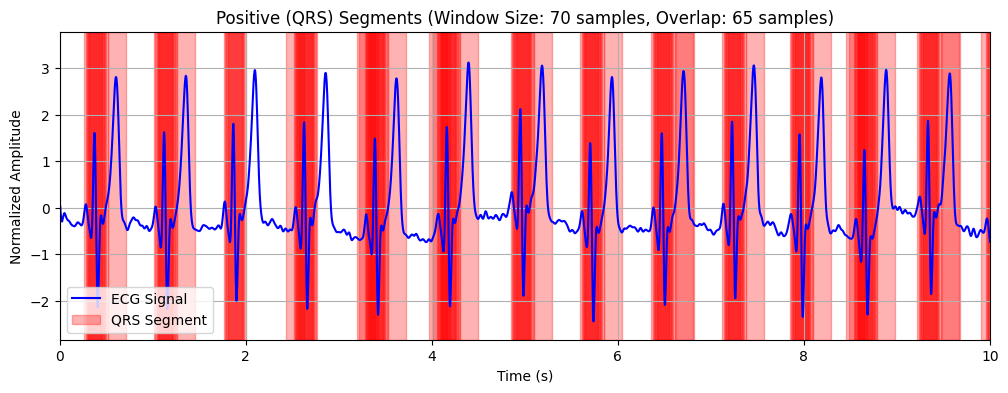

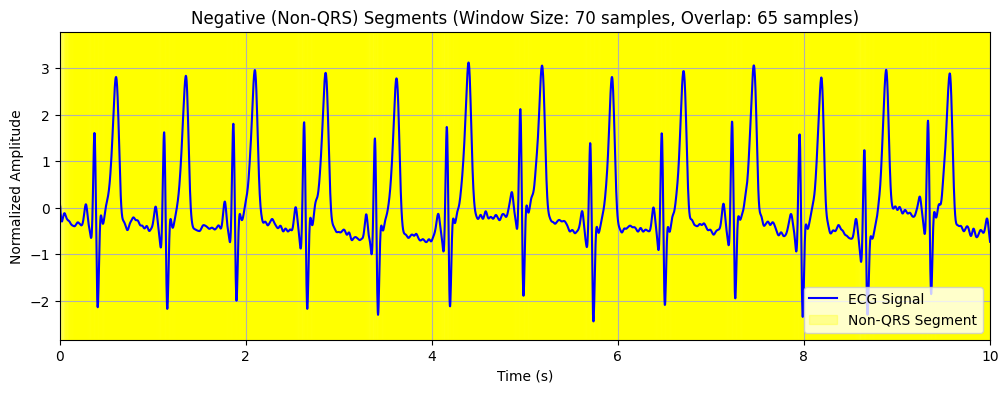

In [149]:
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,10)

Number of positive (QRS) segments: 180
Number of negative (non-QRS) segments: 1247


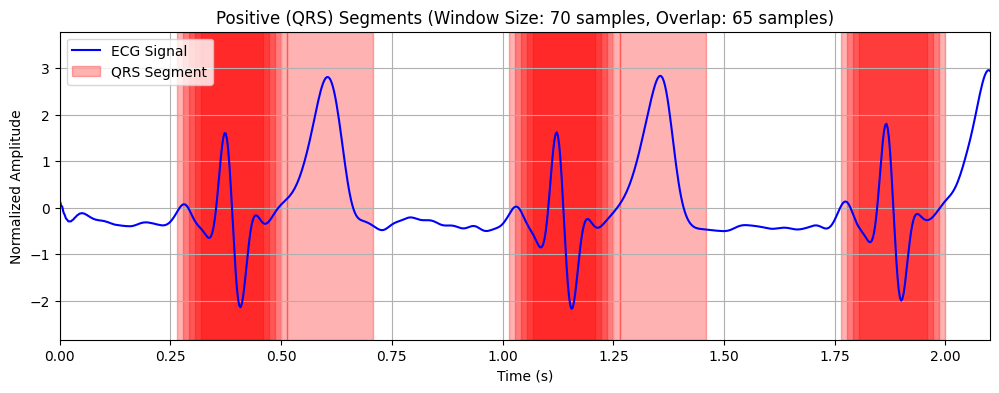

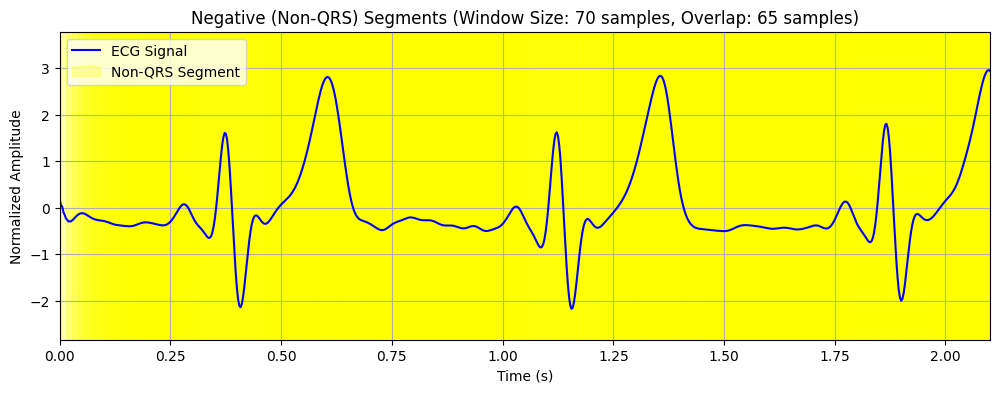

In [150]:
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,2.1)

#### improvement

Number of positive (QRS) segments: 28
Number of negative (non-QRS) segments: 1247


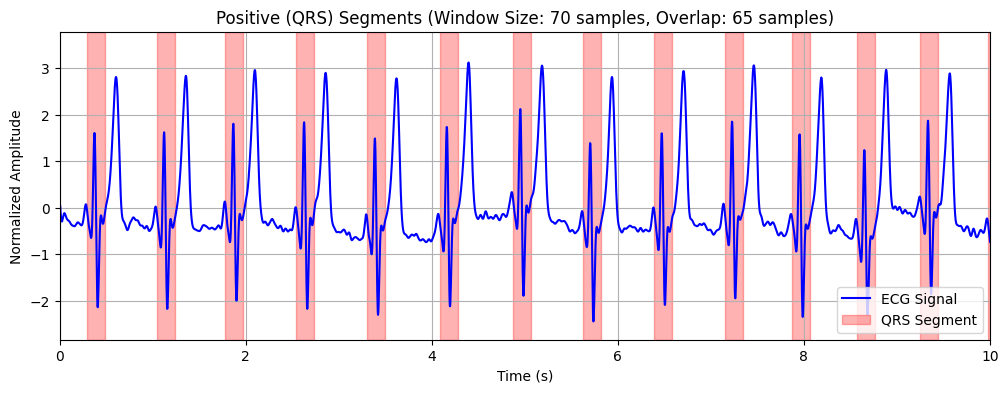

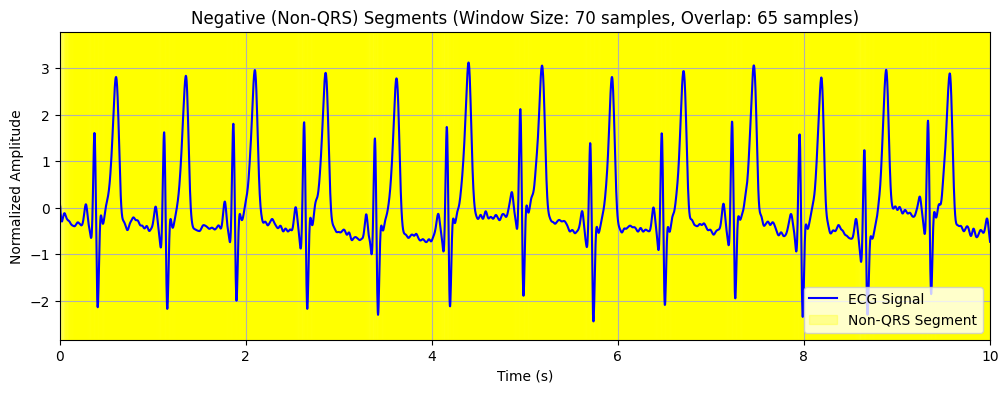

In [151]:
predicted_labels, new_segments, new_start_segments = remove_short_qrs_predictions( predicted_labels, new_segments, new_start_segments)
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,10)

Number of windows to remove: 13
Number of positive (QRS) segments: 28
Number of negative (non-QRS) segments: 521


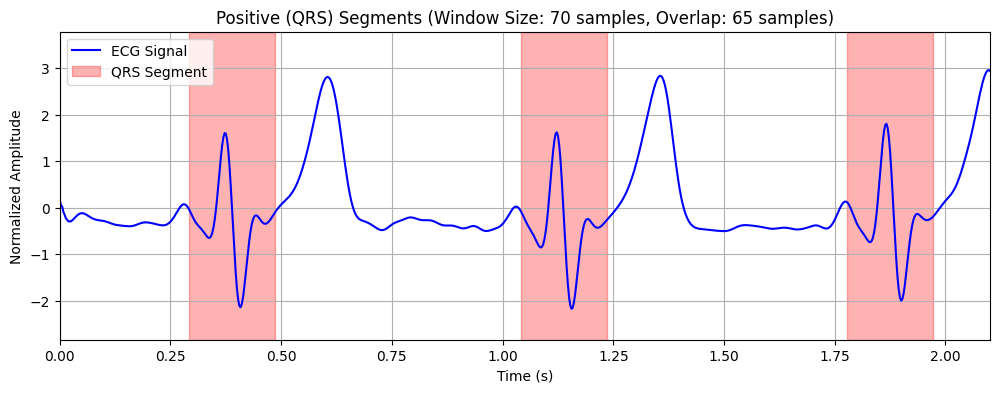

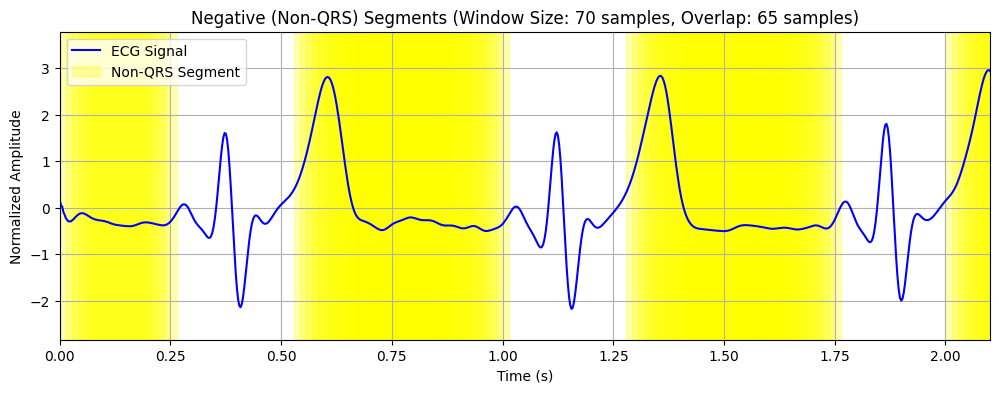

In [152]:

# Example usage:
predicted_labels, new_segments, new_start_segments = remove_touching_negatives( predicted_labels, new_segments, new_start_segments)
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,2.1)

Number of positive (QRS) segments: 28
Number of negative (non-QRS) segments: 521


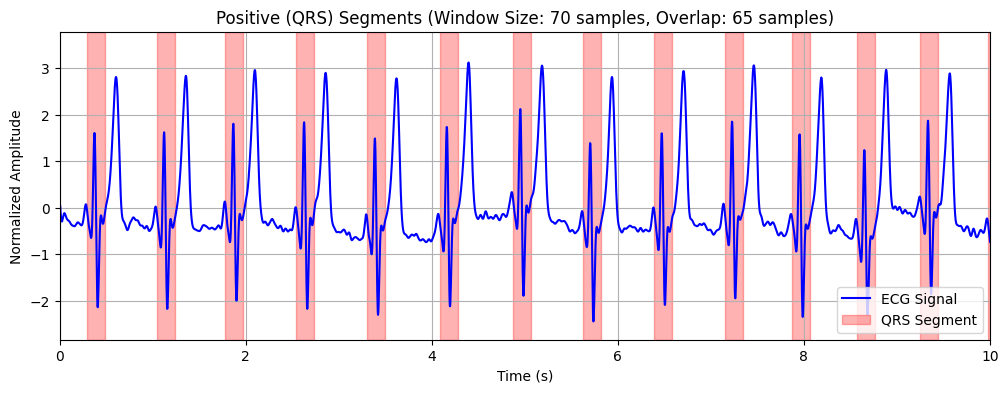

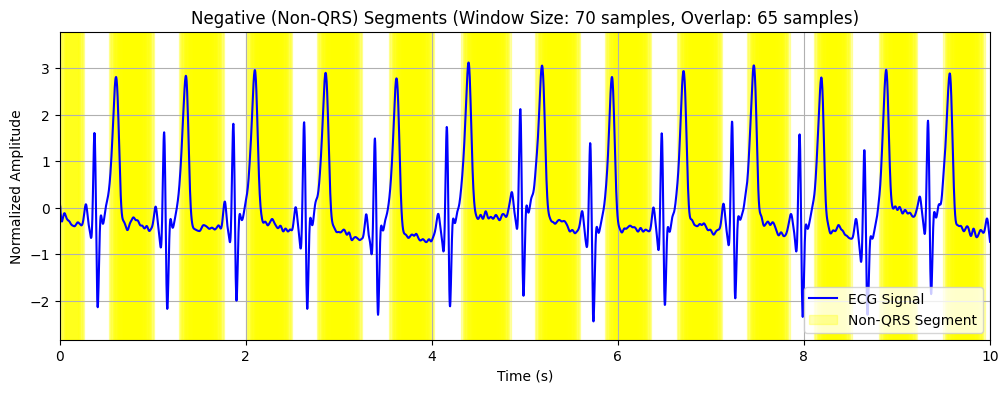

In [153]:
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,10)

### ecgiddb Person_82/rec_2



500
360


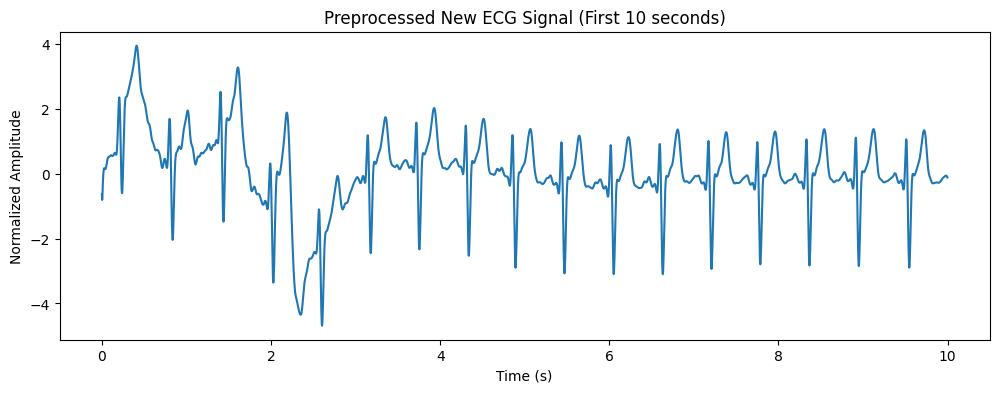

In [218]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
record_dir='/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/'
# Load a new ECG signal (example: another record from MIT-BIH)
# Load a new ECG signal (example: another record from MIT-BIH)
# Load a new ECG signal (example: another record from MIT-BIH)
# Load a new ECG signal (example: another record from MIT-BIH)
new_record_name='Person_84/rec_2'
new_record_name =  record_dir + new_record_name  # Change this to the desired record
new_record = wfdb.rdrecord(new_record_name)
new_ecg_signal = new_record.p_signal[:, 0]  # Assuming single-channel ECG
G_fs = new_record.fs
print(G_fs)
# Example usage
time_axis = np.arange(0, len(new_ecg_signal)) / G_fs  # Time axis in seconds

new_normalized_signal = normalize_signal(smooth_signal(bandpass_filter(new_ecg_signal, 1000), window_size=5))
if G_fs != 360:
            new_normalized_signal = resample_signal(new_normalized_signal, original_fs=G_fs, target_fs=360)
            G_fs = 360

print(G_fs)
# Visualize the preprocessed signal
import matplotlib.pyplot as plt
time_axis = [i / G_fs for i in range(len(new_normalized_signal))]
plt.figure(figsize=(12, 4))
plt.plot(time_axis[:G_fs * 10], new_normalized_signal[:G_fs * 10])
plt.title("Preprocessed New ECG Signal (First 10 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Amplitude")
plt.show()




In [219]:



# Segment the normalized signal
new_segments,new_start_segments = segment_signal(new_normalized_signal, window_size=G_window_size, overlap=G_overlap)

print(f"Extracted {len(new_segments)} segments with window size {G_window_size} and {G_overlap} samples overlap.")



Extracted 1427 segments with window size 70 and 65 samples overlap.


In [220]:
# Reshape segments for CNN+LSTM (adding a channel dimension)
new_segments_reshaped = new_segments.reshape(new_segments.shape[0], new_segments.shape[1], 1)

# Print the shape
print("Shape of input segments for model:", new_segments_reshaped.shape)


Shape of input segments for model: (1427, 70, 1)


In [221]:
# Predict using the trained model
predictions = model.predict(new_segments_reshaped)

# Convert predictions to binary labels (threshold at 0.5)
predicted_labels = (predictions > 0.5).astype(int)

# Print results
print( predicted_labels.flatten())


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[0 0 0 ... 0 1 1]


Number of positive (QRS) segments: 202
Number of negative (non-QRS) segments: 1225


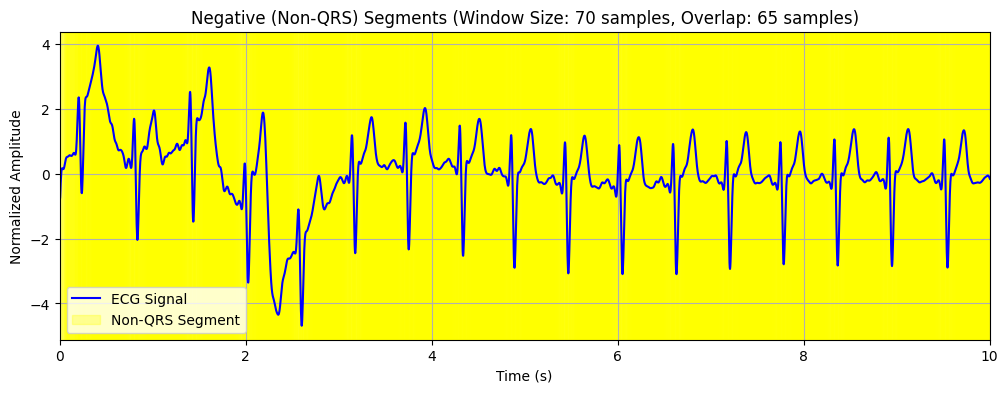

In [222]:
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,10)

Number of positive (QRS) segments: 202
Number of negative (non-QRS) segments: 1225


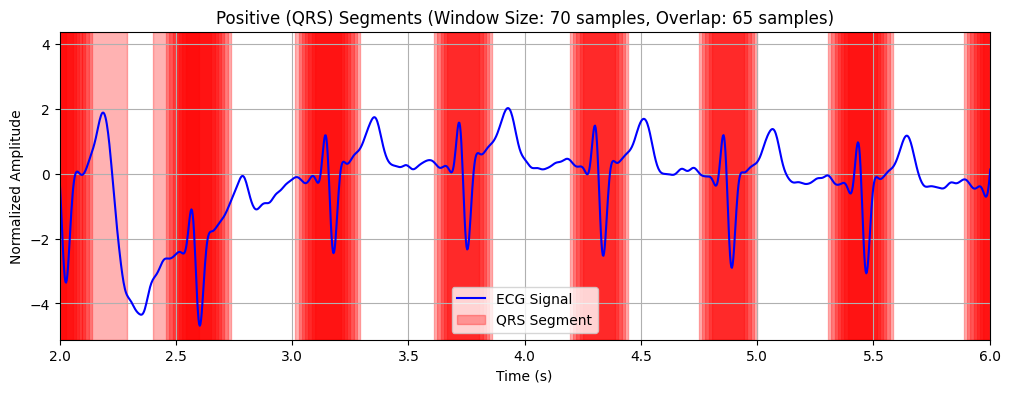

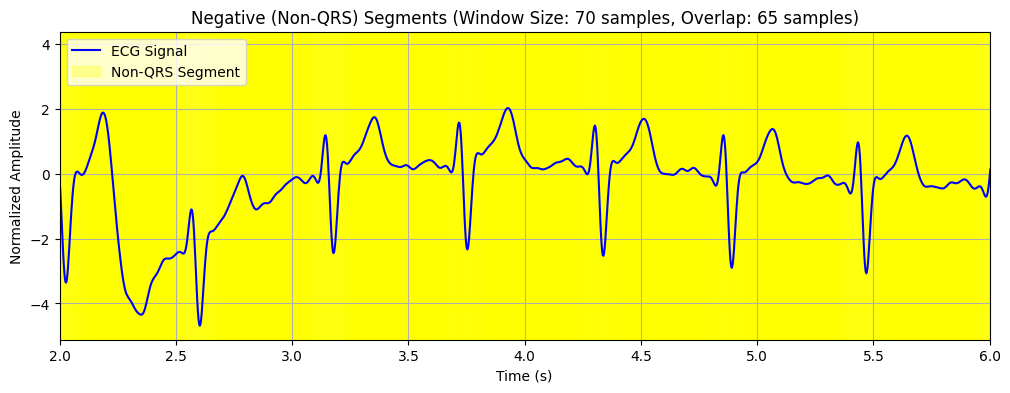

In [223]:
display_segment(new_normalized_signal,predicted_labels,new_start_segments,2,6)

#### improvement

Number of positive (QRS) segments: 33
Number of negative (non-QRS) segments: 1225


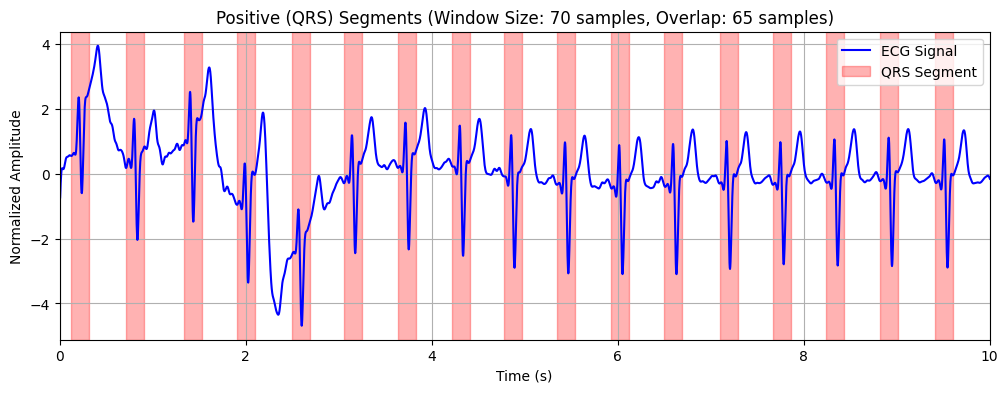

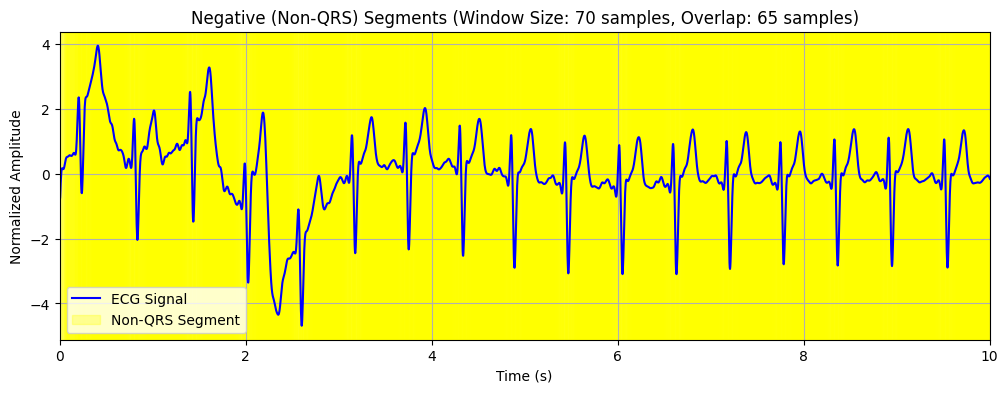

In [224]:
predicted_labels, new_segments, new_start_segments = remove_short_qrs_predictions( predicted_labels, new_segments, new_start_segments , min_len=4)
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,10)

Number of windows to remove: 13
Number of positive (QRS) segments: 33
Number of negative (non-QRS) segments: 373


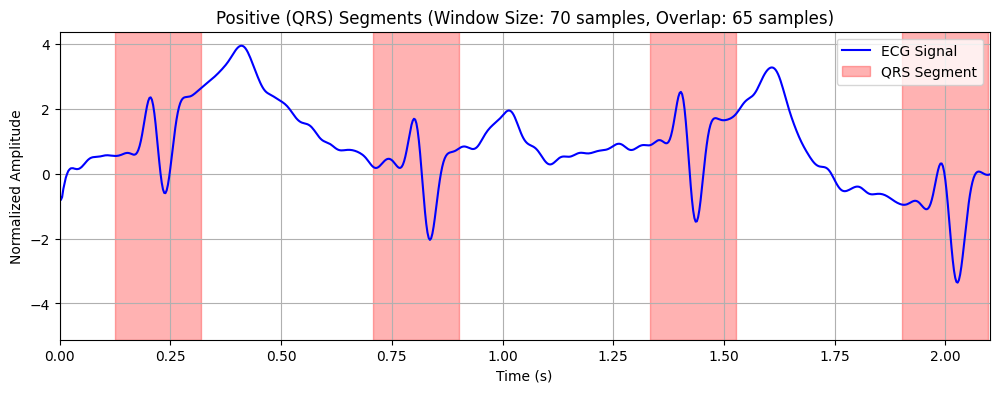

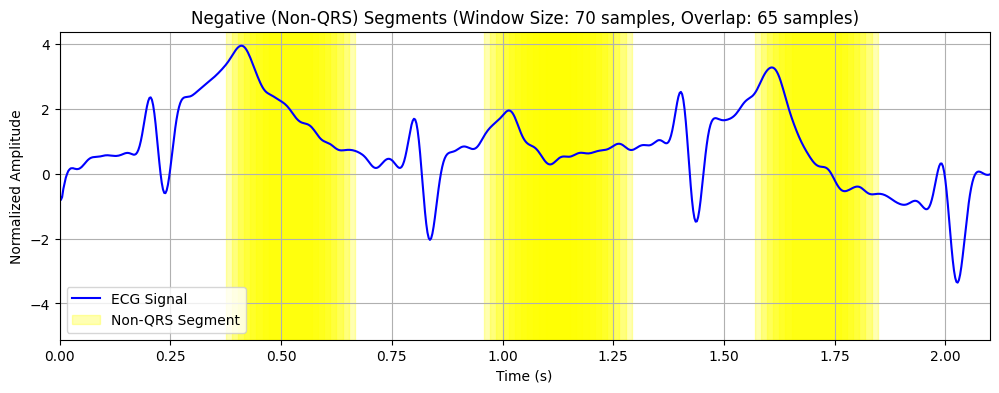

In [225]:

# Example usage:
predicted_labels, new_segments, new_start_segments = remove_touching_negatives( predicted_labels, new_segments, new_start_segments)
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,2.1)

Number of positive (QRS) segments: 33
Number of negative (non-QRS) segments: 373


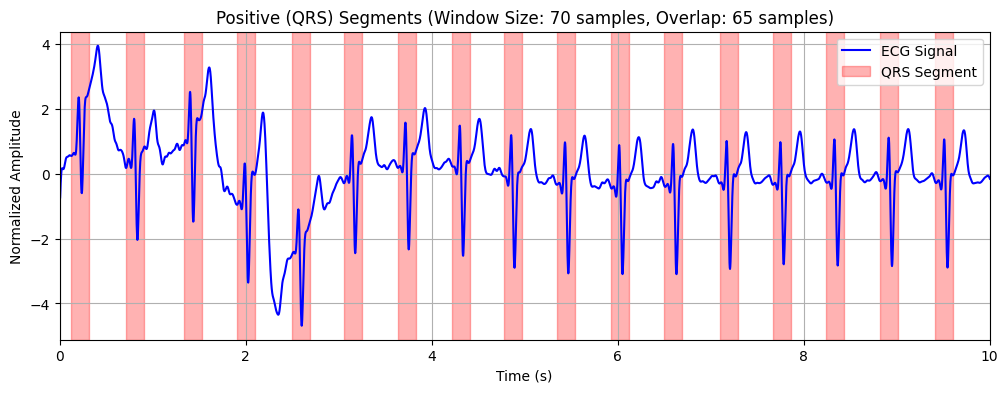

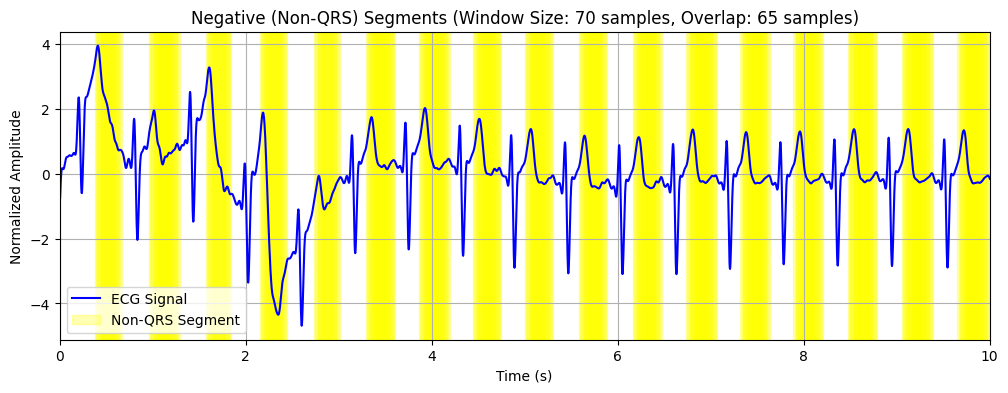

In [226]:
display_segment(new_normalized_signal,predicted_labels,new_start_segments,0,10)